# MNIST Classifier

Run 2, cu train and evaluation sets + test set

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

## Loading Data

- autorii SimpleNet au folosit un split de 60000 train si 10000 eval

- 52000 train + 8000 eval

In [2]:
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training set
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split the dataset into train and eval sets
train_size = 50000
eval_size = 10000
train_subset, eval_subset = random_split(train_dataset, [train_size, eval_size])

# Load the MNIST test set
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [3]:
len(train_loader), len(eval_loader), len(test_loader)

(782, 157, 157)

## Faza 2

[GitHub Repo](https://github.com/Coderx7/SimpleNet_Pytorch/blob/master/cifar/models/simplenet.py) for simplenet310k - cel folosit pt MNIST

In procesul de evaluare, in setul de test, de salvat imaginile care au fost prezise incorect de catre model, cu tuple: `idx`, `clasa prezisa`, `clasa adevarata`. 
De salvat imaginile intr-un director separat format de genul: `"im14_0_9"`.

Pentru a incarca pe fork-ul de pe github: `git push origin master`



In [4]:
import sys

# Add the directory to the Python path in this notebook 
sys.path.append('/home/iustin/SimpleNet_Pytorch/MNIST')

from models.simplenet import simplenet_cifar_310k

In [5]:
import os 
os.getcwd()

'/home/iustin'

In [6]:
import models

model_names = sorted(name for name in models.__dict__
  if name.islower() and not name.startswith("__")
  and callable(models.__dict__[name]))

print('models : ',model_names)

models :  ['simplenet_cifar_310k', 'simplenet_cifar_460k', 'simplenet_cifar_5m', 'simplenet_cifar_5m_extra_pool']


In [7]:
net = models.__dict__['simplenet_cifar_310k'](num_classes=10, in_chans=1)

In [8]:
from torchinfo import summary

summary(net, 
        input_size=(1, 1, 28, 28), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleNet (SimpleNet)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (features)                  [1, 1, 28, 28]       [1, 64, 1, 1]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 64, 28, 28]      640                  True
│    └─BatchNorm2d (1)                   [1, 64, 28, 28]      [1, 64, 28, 28]      128                  True
│    └─ReLU (2)                          [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─Dropout2d (3)                     [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─Conv2d (4)                        [1, 64, 28, 28]      [1, 32, 28, 28]      18,464               True
│    └─BatchNorm2d (5)                   [1, 32, 28, 28]      [1, 32, 28, 28]      64                   True
│    └─ReLU (6)   

In [9]:
# net.eval()
# input_dummy = torch.randn(size=(1, 1, 28, 28)).to(device)
# out = net(input_dummy)
# print(f"output: {out.size()}")

In [10]:
LEARNING_RATE = 0.1
MOMENTUM = 0.9 # default 
WEIGHT_DECAY = 0 # 0.005 
NUM_EPOCH = 150 # 150
EVAL_STEP = 1
SAVE_INTERVAL = 1 # checkpoint
MILESTONES = [20, 40, 60, 80, 100, 120]
STEP_SIZE= 20 # intre 10 si 100 la scheduler step_lr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

net = net.to(device)

criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adadelta(net.parameters(), lr=LEARNING_RATE, rho=0.9, eps=1e-3, # momentum=state['momentum'], # default eps = 1e-6 
                                    #  weight_decay=0.001)

optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY) 
# optimizer = torch.optim.Adam(net.parameters(),lr=LEARNING_RATE,betas=(0.9,0.999),eps=1e-08,weight_decay=0)

# scheduler = lr_scheduler.MultiStepLR(optimizer, MILESTONES, gamma=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)

In [11]:
# #Break
abcd 

NameError: name 'abcd' is not defined

In [12]:
PATH1 = "SimpleNet_Pytorch/MNIST/checkpoint_loss2"
PATH2 = "SimpleNet_Pytorch/MNIST/checkpoint_acc2"

checkpoint_filename = 'checkpoint.pth'
checkpoint_path1 = os.path.join(PATH1, checkpoint_filename)
checkpoint_path2 = os.path.join(PATH2, checkpoint_filename)

In [ ]:
def train(net, device, train_loader, criterion, optimizer, train_loss_collector, train_accuracy_collector):
     for epoch in range(NUM_EPOCH):
        net.train()
        correct = 0
        epoch_loss = list()
        eval_loss = list()
        accuracy = list() 
        eval_accuracy = list()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            pred = torch.max(output.data, 1)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy.append(correct)
            epoch_accuracy =  100. * correct / len(train_loader.dataset)
        train_loss_collector.append(np.round(np.mean(epoch_loss),5))
        train_accuracy_collector.append(epoch_accuracy)
        print(f'Epoch: {epoch}/{NUM_EPOCH} \t Loss: {np.round(np.mean(epoch_loss),5)}')
        print(f'Train Accuracy: {(100. * correct / len(train_loader.dataset)):.3f}%')
        scheduler.step()
        if epoch % EVAL_STEP == 0:
            evaluation(net, device, eval_loader, criterion, eval_loss_collector, eval_accuracy_collector)
        if epoch % SAVE_INTERVAL == 0: 
            torch.save({
                'epoch': epoch,
                'net_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch_loss': epoch_loss,
                'eval_loss': eval_loss,
                'train_loss_collector': train_loss_collector,
                'eval_loss_collector': eval_loss_collector,
                'all_preds': all_preds,
                'all_targets': all_targets,
                'LEARNING_RATE': LEARNING_RATE,
                'MOMENTUM': MOMENTUM,
                'WEIGHT_DECAY': WEIGHT_DECAY,
                'NUM_EPOCH': NUM_EPOCH,
                'EVAL_STEP': EVAL_STEP,
                'SAVE_INTERVAL': SAVE_INTERVAL,
                'MILESTONES': MILESTONES,
                'STEP_SIZE': STEP_SIZE,
            }, checkpoint_path1)
            torch.save({
                'epoch': epoch,
                'net_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch_accuracy': epoch_accuracy,
                'eval_accuracy': eval_accuracy,
                'train_accuracy_collector': train_accuracy_collector,
                'eval_accuracy_collector': eval_accuracy_collector,
                'all_preds': all_preds,
                'all_targets': all_targets,
                'LEARNING_RATE': LEARNING_RATE,
                'MOMENTUM': MOMENTUM,
                'WEIGHT_DECAY': WEIGHT_DECAY,
                'NUM_EPOCH': NUM_EPOCH,
                'EVAL_STEP': EVAL_STEP,
                'SAVE_INTERVAL': SAVE_INTERVAL,
                'MILESTONES': MILESTONES,
                'STEP_SIZE': STEP_SIZE,
            }, checkpoint_path2)

: 

: 

In [ ]:
def evaluation(net, device, eval_loader, criterion, eval_loss_collector, eval_accuracy_collector):
    net.eval() 
    correct_eval = 0
    eval_loss = list()
    eval_acc = list()
    with torch.no_grad():
        for data, target in eval_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            loss = criterion(output, target)
            eval_loss.append(loss.item())
            preds = output.argmax(dim=1, keepdim=True)
            correct_eval += preds.eq(target.view_as(preds)).sum().item()
            eval_acc.append(correct_eval)
            eval_accuracy =  100. * correct_eval / len(eval_loader.dataset)
        eval_loss_collector.append(np.round(np.mean(eval_loss),5))
        eval_accuracy_collector.append(eval_accuracy)
        print(f'Eval loss: {np.round(np.mean(eval_loss), 5)} Eval Accuracy: {correct_eval}/{len(eval_loader.dataset)}'
              f' - {(100. * correct_eval / len(eval_loader.dataset)):.3f}%')
    all_preds.extend(preds)
    all_targets.extend(target)

: 

: 

In [ ]:
train_loss_collector = list()
train_accuracy_collector = list()
eval_loss_collector = list()
eval_accuracy_collector = list()
all_preds = list()
all_targets = list()
print('Start training...')
train(net, device, train_loader, criterion, optimizer, train_loss_collector, train_accuracy_collector)
print('Finish training!')

Start training...
Epoch: 0/150 	 Loss: 0.13143
Train Accuracy: 95.922%
Eval loss: 0.07276 Eval Accuracy: 9790/10000 - 97.900%
Epoch: 1/150 	 Loss: 0.04525
Train Accuracy: 98.624%
Eval loss: 0.06848 Eval Accuracy: 9826/10000 - 98.260%
Epoch: 2/150 	 Loss: 0.03032
Train Accuracy: 99.092%
Eval loss: 0.03588 Eval Accuracy: 9900/10000 - 99.000%
Epoch: 3/150 	 Loss: 0.02287
Train Accuracy: 99.280%
Eval loss: 0.03558 Eval Accuracy: 9904/10000 - 99.040%
Epoch: 4/150 	 Loss: 0.01993
Train Accuracy: 99.336%
Eval loss: 0.03206 Eval Accuracy: 9910/10000 - 99.100%
Epoch: 5/150 	 Loss: 0.01485
Train Accuracy: 99.552%
Eval loss: 0.03318 Eval Accuracy: 9911/10000 - 99.110%
Epoch: 6/150 	 Loss: 0.0131
Train Accuracy: 99.584%
Eval loss: 0.03891 Eval Accuracy: 9908/10000 - 99.080%
Epoch: 7/150 	 Loss: 0.01344
Train Accuracy: 99.590%
Eval loss: 0.03062 Eval Accuracy: 9927/10000 - 99.270%
Epoch: 8/150 	 Loss: 0.00931
Train Accuracy: 99.686%
Eval loss: 0.02967 Eval Accuracy: 9922/10000 - 99.220%
Epoch: 9/15

: 

: 

In [ ]:
#break
# abcd

: 

: 

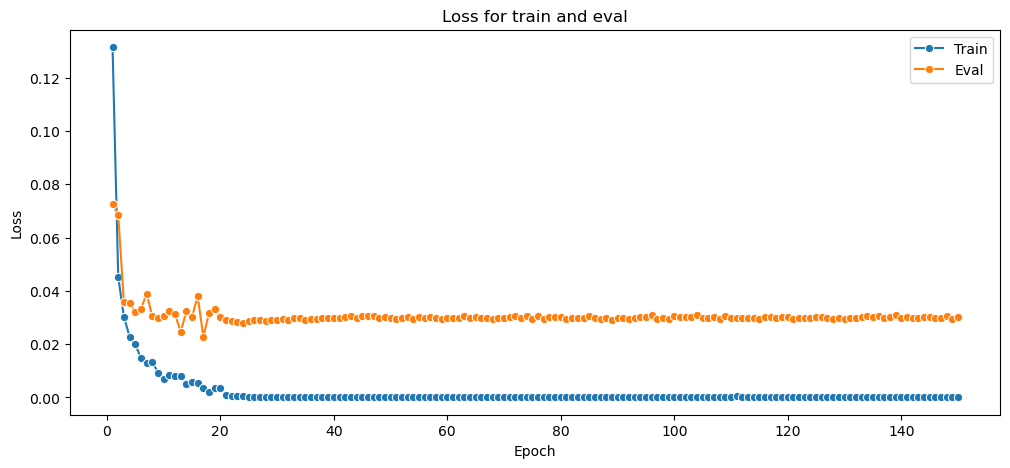

: 

: 

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=train_loss_collector, label='Train', marker='o')
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=eval_loss_collector, label='Eval', marker='o')
plt.title('Loss for train and eval')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show();

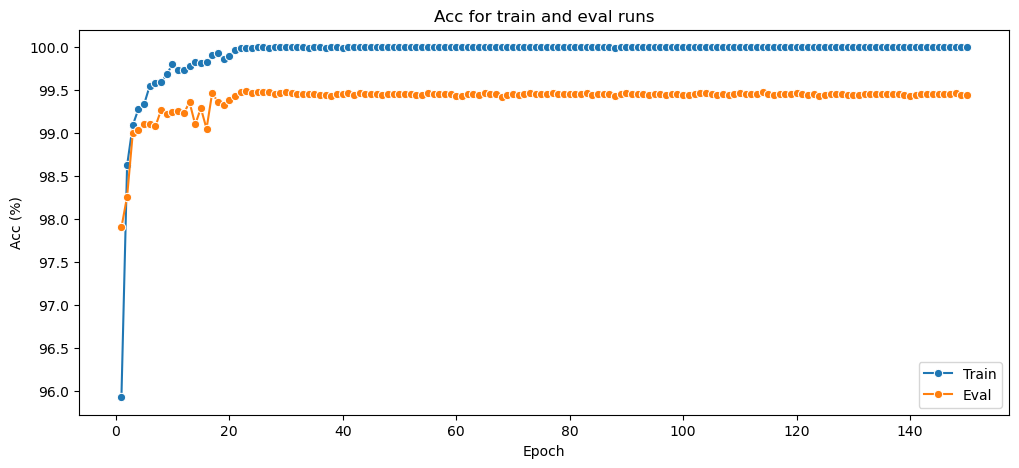

: 

: 

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=train_accuracy_collector, label='Train', marker='o')
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=eval_accuracy_collector, label='Eval', marker='o')
plt.title('Acc for train and eval runs')
plt.ylabel('Acc (%)')
plt.xlabel('Epoch')
plt.show();

In [13]:
# load checkpoint
checkpoint_path1 = "SimpleNet_Pytorch/MNIST/checkpoint_loss2/checkpoint.pth"
checkpoint = torch.load(checkpoint_path1)
net.load_state_dict(checkpoint['net_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
all_preds = checkpoint['all_preds']
all_targets = checkpoint['all_targets']

In [ ]:
# checkpoint

: 

: 

In [ ]:
data = {
    'Train Loss': train_loss_collector,
    'Train Accuracy': train_accuracy_collector,
    'Eval Loss': eval_loss_collector,
    'Eval Accuracy': eval_accuracy_collector
}

df = pd.DataFrame(data)

df.index.name = 'Epoch'

print(df)

       Train Loss  Train Accuracy  Eval Loss  Eval Accuracy
Epoch                                                      
0         0.13143          95.922    0.07276          97.90
1         0.04525          98.624    0.06848          98.26
2         0.03032          99.092    0.03588          99.00
3         0.02287          99.280    0.03558          99.04
4         0.01993          99.336    0.03206          99.10
...           ...             ...        ...            ...
145       0.00012         100.000    0.02995          99.45
146       0.00012         100.000    0.02996          99.46
147       0.00016         100.000    0.03051          99.47
148       0.00015         100.000    0.02954          99.44
149       0.00017          99.998    0.03025          99.44

[150 rows x 4 columns]


: 

: 

In [ ]:
# pe jupyterhub
file_path = 'SimpleNet_Pytorch/MNIST/training_test_metrics2.csv' 
df.to_csv(file_path, index=True)

: 

: 

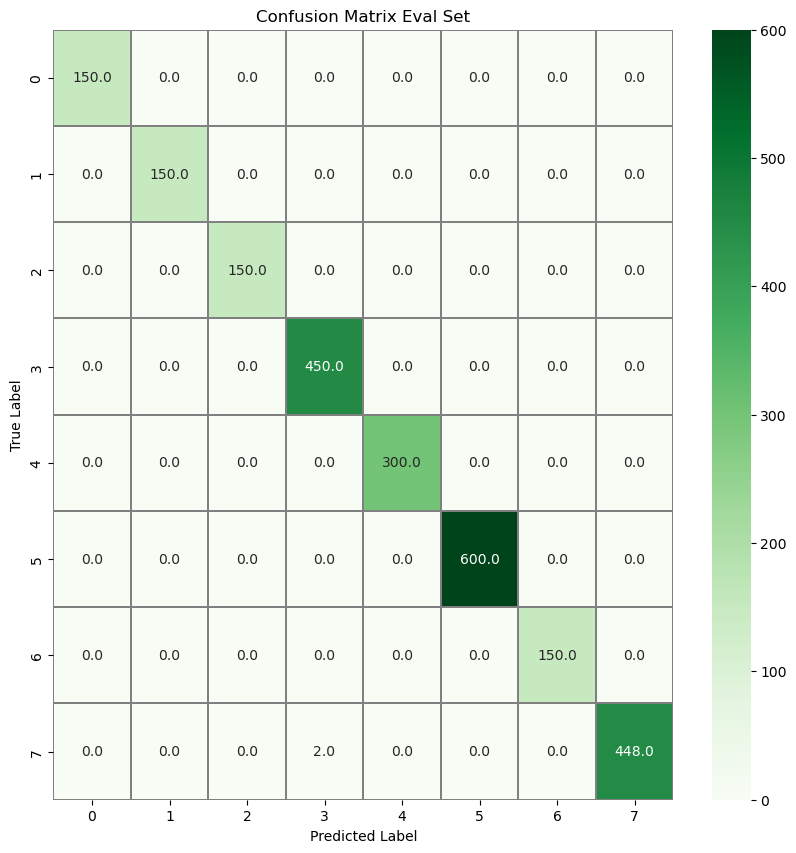

In [14]:
preds = [tensor.item() for tensor in all_preds]
targets = [tensor.item() for tensor in all_targets]
confusion_mtx = confusion_matrix(targets, preds)
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Eval Set")
plt.show()

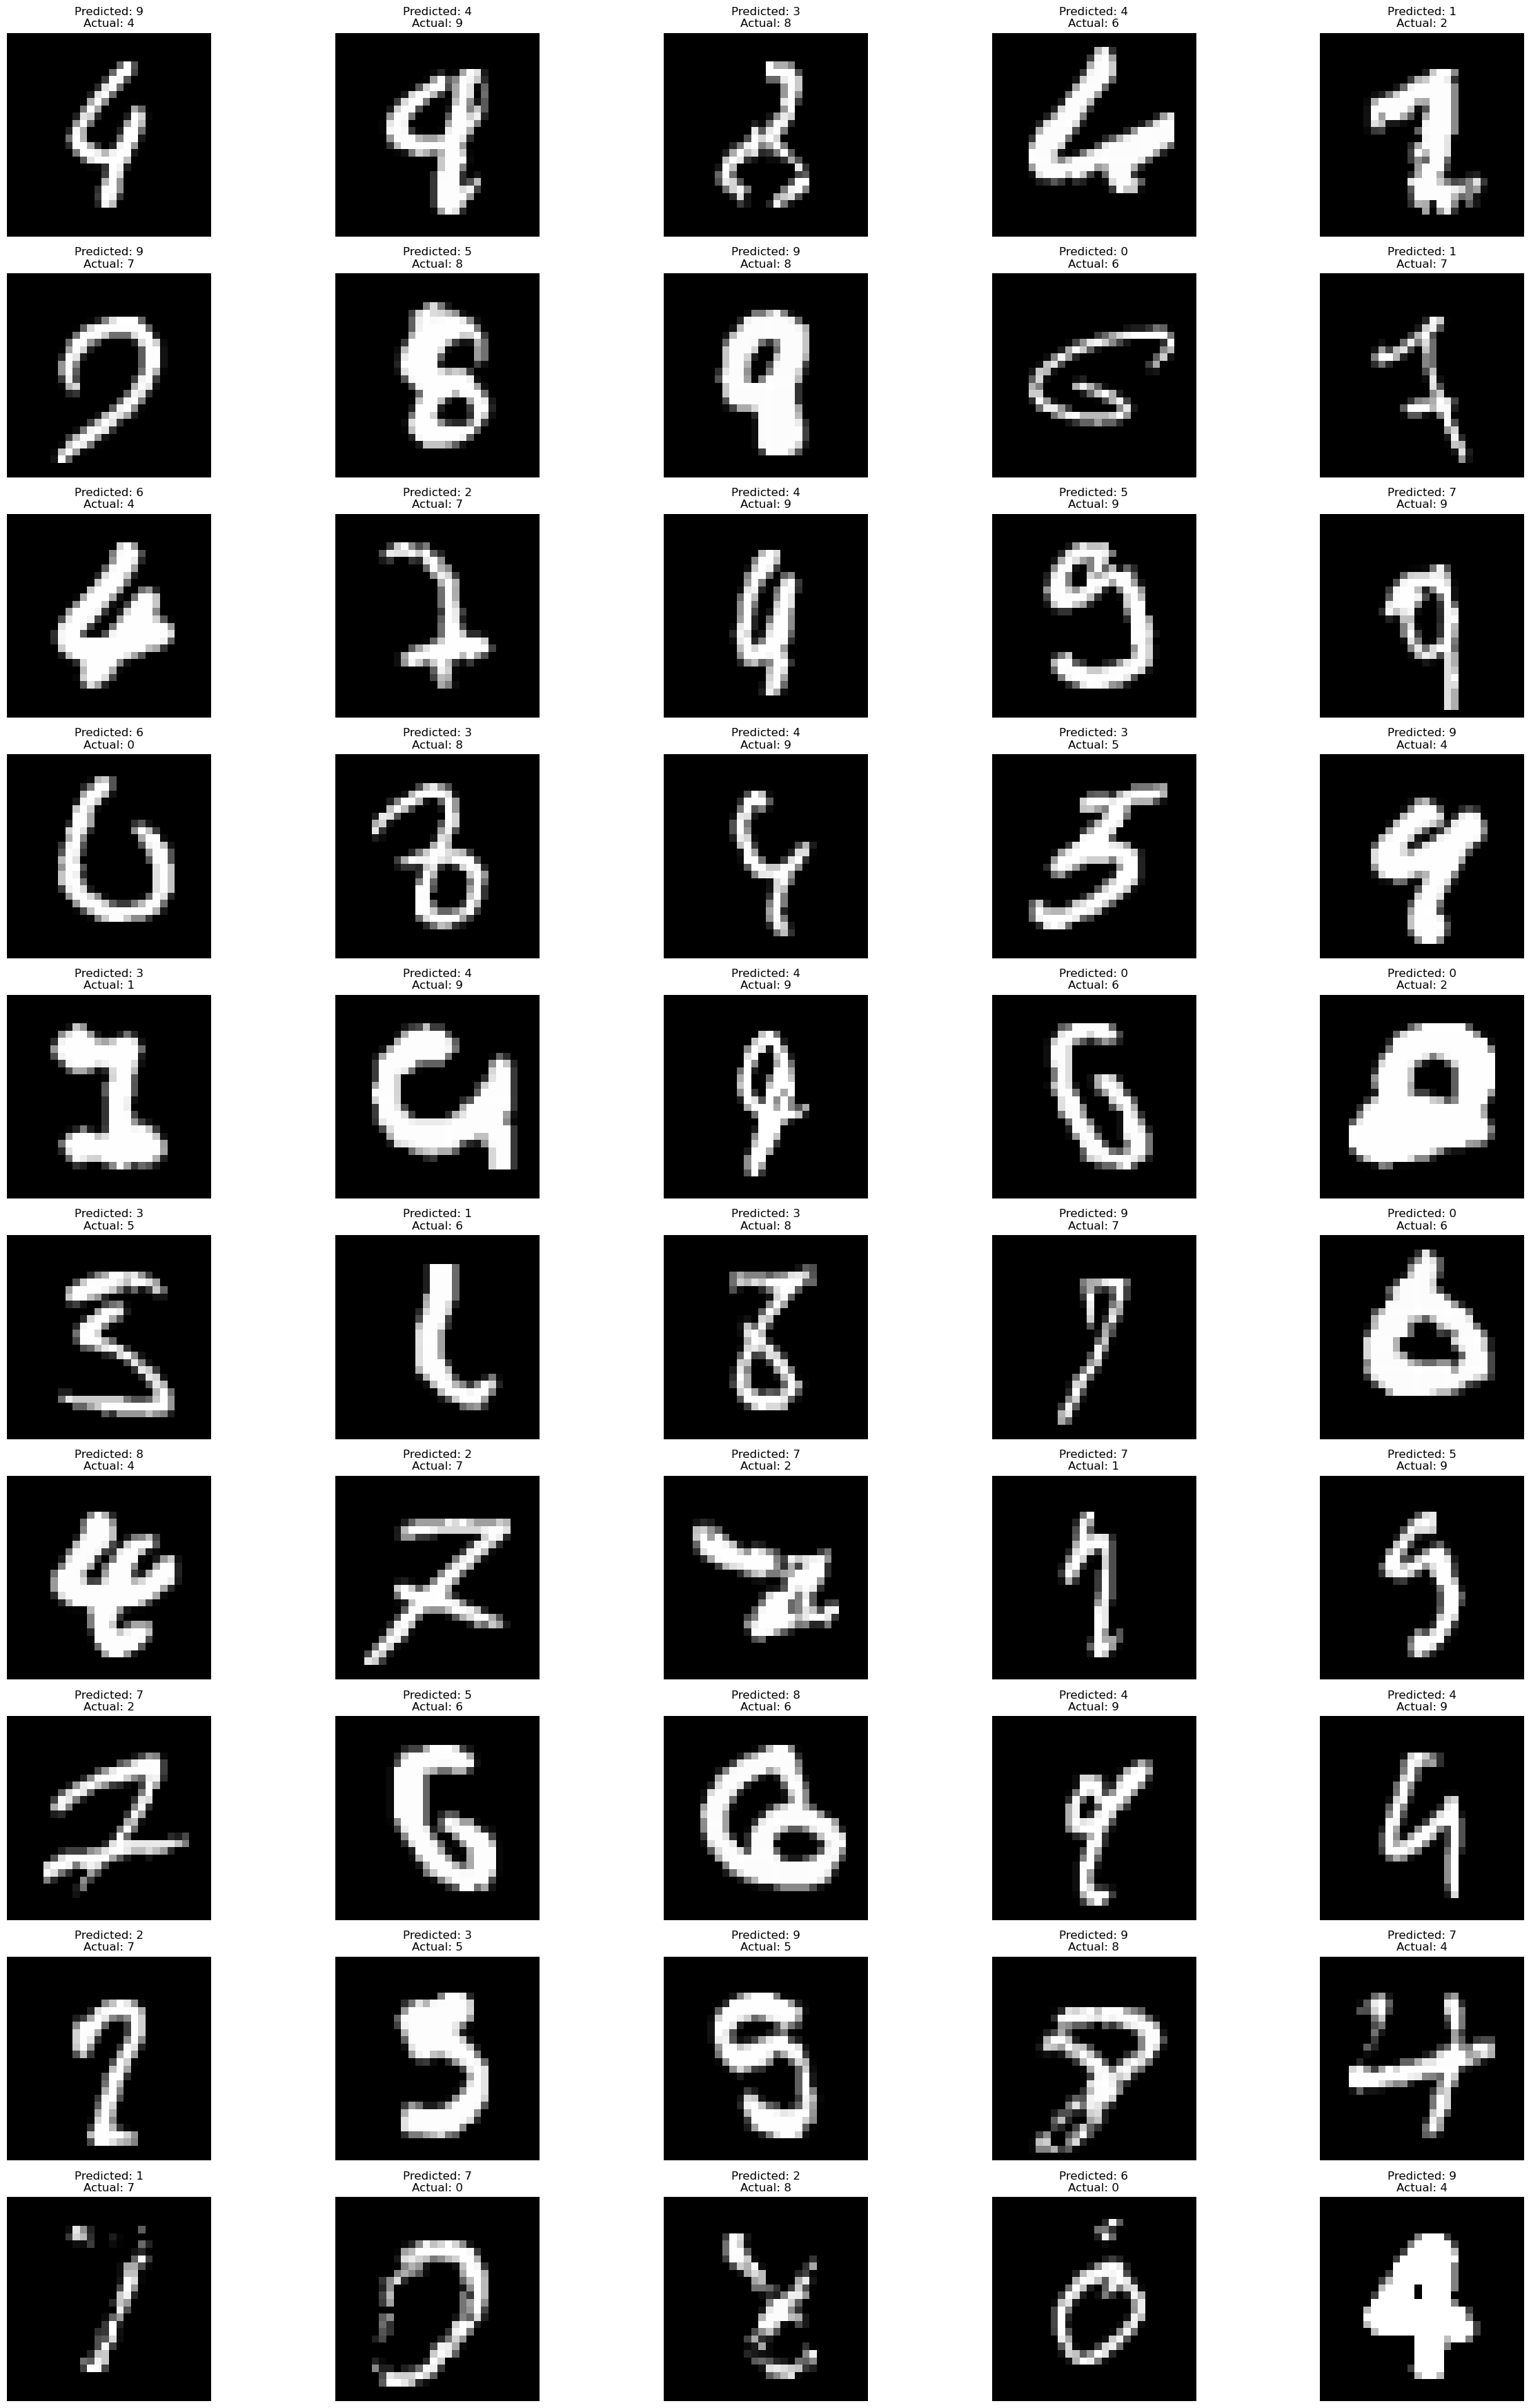

In [15]:
def plot_misclassified_images(net, device, test_loader, classes):
    net = net.to(device)
    net.eval()  
    misclassified = []

    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            pred = output.argmax(dim=1, keepdim=True)  

            # Check for misclassified images
            misclassified_mask = ~pred.eq(target.view_as(pred))
            misclassified_images = data[misclassified_mask]
            misclassified_preds = pred[misclassified_mask]
            misclassified_targets = target.view_as(pred)[misclassified_mask]

            # Store the misclassified images and their predicted/actual labels
            for image, pred, actual in zip(misclassified_images, misclassified_preds, misclassified_targets):
                misclassified.append((image, pred, actual))

            # Stop after collecting a certain number of misclassified images
            if len(misclassified) >= 50:
                break

    # Plot the misclassified images
    fig, axes = plt.subplots(10, 5, figsize=(25, 35))
    for i, (image, pred, actual) in enumerate(misclassified[:50]):
        ax = axes[i//5, i%5]
        ax.imshow(image.cpu().numpy().squeeze(), cmap='gray')
        ax.set_title(f'Predicted: {classes[pred.item()]}\nActual: {classes[actual.item()]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_misclassified_images(net, device, test_loader, classes)

> ! 35 imagini misclassified pe test set si 36 in procesul de antrenare pe setul de eval

In [ ]:
from pathlib import Path
from PIL import Image
def save_misclassified_samples(net, device, test_loader, save_dir):
    net.eval()  
    misclassified_samples = []

    with torch.no_grad():  
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            pred = output.argmax(dim=1, keepdim=True)  

            # Check for misclassified images
            misclassified_mask = ~pred.eq(target.view_as(pred))
            misclassified_data = data[misclassified_mask].cpu()
            misclassified_targets = target[misclassified_mask.squeeze()].cpu()

            for img, label in zip(misclassified_data, misclassified_targets):
                misclassified_samples.append((img, label.item()))
    # Save the misclassified images to the set path
    if misclassified_samples:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        for i, (img, label) in enumerate(misclassified_samples):
            img = transforms.ToPILImage()(img.squeeze())
            # Convert grayscale image to RGB with a single channel
            img = img.convert('L')  
            image_3_channel = np.stack((img,)*3, axis=-1)
            image_3_channel_pil = Image.fromarray(image_3_channel)
            # Save 
            image_3_channel_pil.save(save_dir / f'misclassified_{i}_{label}.jpeg')
    else:
        return None
save_misclassified_samples(net.to(device), device, test_loader, 'SimpleNet_Pytorch/MNIST/misclassified_samples2')

: 

: 

se salveaza doar toate ca grayscale, dar tot nu merge guided backprop

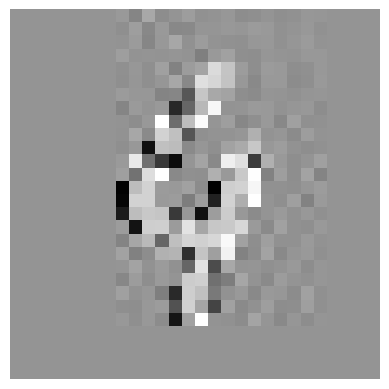

In [16]:
image_path = 'SimpleNet_Pytorch/MNIST/misclassified_samples2/misclassified_0_4.jpeg'
image = Image.open(image_path)

# Display the image
plt.imshow(image)  # Use cmap='gray' if it's a grayscale image
plt.axis('off')  
plt.show()

# De facut:

1. splitul dintre train validation si test
este train val split standardizat? daca nu, facem cum consideram?

2. guided backprop

3. cnn layer visualization

## Guided backpropagation

Layer-wise backprop pentru neuronii nu doar din fully-connected layers (pt clasificare) 

! Cea mai simpla implementare 

> Guided backpropagation implementation: 

> 1. https://github.com/ashutosh1919/explainable-cnn
> 2. https://github.com/MECLabTUDA/M3d-Cam

In [ ]:
# 1
from explainable_cnn import CNNExplainer

classes_dict = {i: class_name for i, class_name in enumerate(classes)}
x_cnn = CNNExplainer(net, classes_dict)

: 

: 

In [ ]:
# Perform guided backpropagation on the grayscale image
guided_backprop = x_cnn.get_guided_back_propagation(
    'SimpleNet_Pytorch/MNIST/misclassified_samples2/misclassified_0_4.jpeg',
    8, # The channel index of the grayscale image
    (28, 28)
)

# Display the guided backpropagation result
plt.imshow(guided_backprop.astype('uint8'), cmap='gray')
plt.axis('off')
plt.show()

RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 3, 28, 28] to have 1 channels, but got 3 channels instead

: 

: 

In [ ]:

# Perform guided backpropagation on the image
guided_backprop = x_cnn.get_guided_back_propagation('SimpleNet_Pytorch/MNIST/misclassified_samples2/misclassified_0_4.jpeg', 1, (28, 28))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
ax1.imshow(image_3_channel_pil)
ax1.set_title('Original Image')
ax1.axis('off')

# Display the guided backpropagation result
ax2.imshow(guided_backprop.astype('uint8'), cmap='gray')
ax2.set_title('Guided Backpropagation')
ax2.axis('off')

# Show the figure
plt.tight_layout()
plt.show()


RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 3, 28, 28] to have 1 channels, but got 3 channels instead

: 

: 

2. https://github.com/MECLabTUDA/M3d-Cam

! new version of Gcam: https://github.com/Karol-G/Gcam

eroare la parametrul `label`: 

`Best label mode works only with a batch size of one. You need to choose a specific label or None with a batch size bigger than one.`


In [ ]:
from medcam import medcam

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
net = medcam.inject(net, output_dir='SimpleNet_Pytorch/MNIST/attention_maps', backend='gbp', layer='auto', label='best', save_maps=True)

In [ ]:
test_loader2 = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
net = net.to(device)
net.eval()
with torch.no_grad():
    for data,target in test_loader2:
        data, target = data.to(device), target.to(device)
        output = net(data).to(device)
        # _ = net(batch[0].to(device))

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

3. https://github.com/utkuozbulak/pytorch-cnn-visualizations

Guided backprop and CNN layer visualization

packages for repo codespace: 

torch==2.1.0
torchvision==0.16.0
numpy==1.26.1
matplotlib==3.7.2
pillow(PIL)==9.5.0

In github codespace am creat un environment cu package-urile de mai sus si am replicat intr-un test.ipynb rezultatele din guided_backprop.py.

S-a creat si fork pe contul meu, deci merge sa il rulez local si eventual sa pasez direct imaginile, daca merge.

In [17]:
image_path

'SimpleNet_Pytorch/MNIST/misclassified_samples2/misclassified_0_4.jpeg'

In [18]:
from utils.misc_functions import get_example_params, save_gradient_images, convert_to_grayscale, get_positive_negative_saliency
from utils.guided_backprop import GuidedBackprop
import utils.layer_activation_with_guided_backprop

# guided backprop
GBP = GuidedBackprop(net)
# Convert image to grayscale
image_gray = image.convert('L')
# Convert image to tensor and add an extra dimension
image_tensor = transforms.ToTensor()(image_gray).unsqueeze(0)
# Get gradients
guided_grads = GBP.generate_gradients(image_tensor.to(device), 8)

RuntimeError: invalid gradient at index 0 - expected device cuda:0 but got cpu